Importing Libraries


In [ ]:
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import plotly.express as px


from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
plt.style.use('fivethirtyeight')


Get Data From Kaggle


In [ ]:
!pip install opendatasets 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/bhanuprasanna527/stock-market-prediction")

Skipping, found downloaded files in "./stock-market-prediction" (use force=True to force download)


Read Data

In [ ]:
df = pd.read_csv("/content/stock-market-prediction/2 Year IBM Stock Data.csv")
df.head()

time     open    high      low   close  volume
0  3/25/2022 19:19  131.300  131.30  131.300  131.30     718
1  3/25/2022 19:18  131.300  131.30  131.300  131.30     282
2  3/25/2022 17:50  131.300  131.30  131.300  131.30     100
3  3/25/2022 16:59  131.340  131.35  131.340  131.35    1427
4  3/25/2022 16:42  131.326  131.35  131.326  131.35    1326

In [ ]:
df.tail()

time       open       high        low      close  volume
216878  4/6/2020 7:27  95.385037  95.385037  95.385037  95.385037     854
216879  4/6/2020 7:25  94.530379  94.530379  94.530379  94.530379     450
216880  4/6/2020 7:08  94.703037  94.703037  94.703037  94.703037     436
216881  4/6/2020 7:02  95.479999  95.479999  95.479999  95.479999     575
216882  4/6/2020 7:01  94.979290  94.979290  94.979290  94.979290     452

In [ ]:
df.isna().any()

time      False
open      False
high      False
low       False
close     False
volume    False
dtype: bool

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216883 entries, 0 to 216882
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    216883 non-null  object 
 1   open    216883 non-null  float64
 2   high    216883 non-null  float64
 3   low     216883 non-null  float64
 4   close   216883 non-null  float64
 5   volume  216883 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 9.9+ MB


In [ ]:
df.shape

(216883, 6)

In [ ]:
df.duplicated().sum()

0

Set time as index


In [ ]:
df['time'] = pd.to_datetime(df['time'])
df.set_index('time',inplace=True)

In [ ]:
df.head()

open    high      low   close  volume
time                                                         
2022-03-25 19:19:00  131.300  131.30  131.300  131.30     718
2022-03-25 19:18:00  131.300  131.30  131.300  131.30     282
2022-03-25 17:50:00  131.300  131.30  131.300  131.30     100
2022-03-25 16:59:00  131.340  131.35  131.340  131.35    1427
2022-03-25 16:42:00  131.326  131.35  131.326  131.35    1326

**Data** Visualization

In [ ]:
fig = px.line(x=df.index,y=df['close'])
fig.show()

In [ ]:
df.index.min()

Timestamp('2020-04-06 07:01:00')

In [ ]:
df.index.max()


Timestamp('2022-03-25 19:19:00')

In [ ]:
dataset = df.filter(['close'])

data = dataset.values

data = data.reshape(-1,1)

 Data Normalizing and spliting

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))



In [ ]:

data = scaler.fit_transform(data)
train_set = int(len(data)*0.8)
test_set = train_set - len(data)
train, test = data[0:train_set,:], data[train_set:len(data),:]

In [ ]:

def create_dataset(dataset, predictiontime):
    
    dataX, dataY = [],[]
    
    for i in range(predictiontime,dataset.shape[0]):
        dataX.append(dataset[i - predictiontime : i, 0])
        dataY.append(dataset[i, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
x_train, y_train = create_dataset(train, 60)
x_test, y_test = create_dataset(test,60)


x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [ ]:
x_train.shape

(173446, 60, 1)

In [ ]:
x_test.shape

(43317, 60, 1)

**Create and fit LSTM model**

In [ ]:

model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.fit(x_train,y_train,epochs=5, batch_size=32)

test_predict = model.predict(x_test)

Epoch 1/5
5421/5421 [==============================] - 91s 15ms/step - loss: 0.0011
Epoch 2/5
5421/5421 [==============================] - 83s 15ms/step - loss: 3.4096e-04
Epoch 3/5
5421/5421 [==============================] - 84s 16ms/step - loss: 2.6887e-04
Epoch 4/5
5421/5421 [==============================] - 83s 15ms/step - loss: 2.4831e-04
Epoch 5/5
1354/1354 [==============================] - 11s 7ms/step


In [ ]:
test_predict = scaler.inverse_transform(test_predict)

y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))

 Visualizing the prediction of the neural network

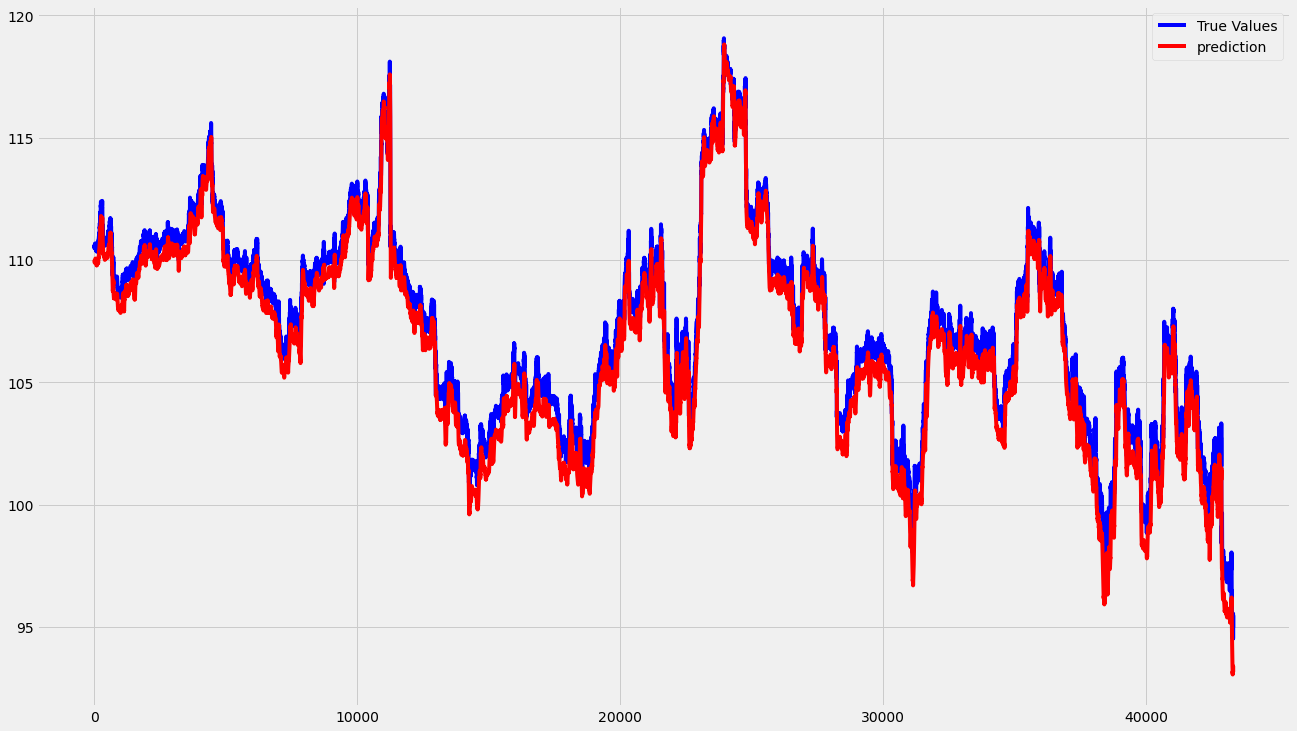

In [ ]:

fig, ax = plt.subplots(figsize=(20,12))

ax.plot(y_test_scaled, color='blue', label='True Values')
plt.plot(test_predict, color='red',label='prediction')
plt.legend()
plt.show()

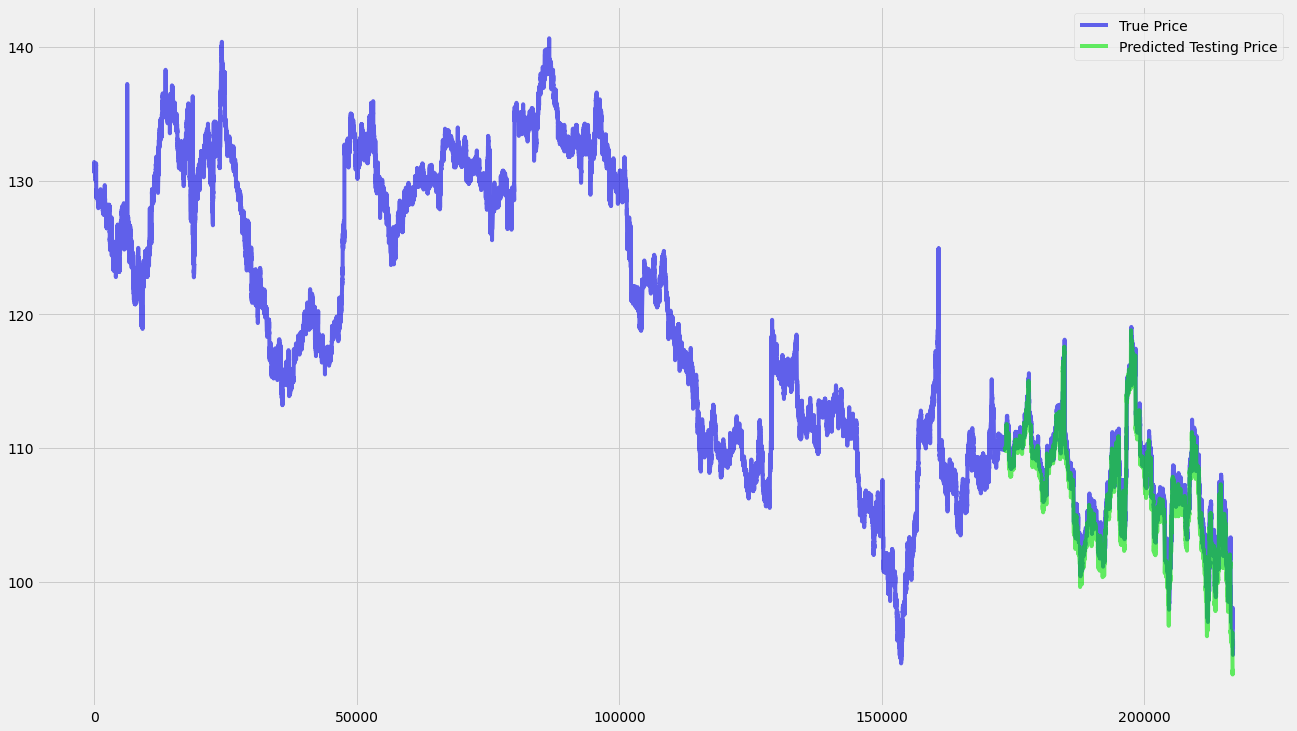

In [ ]:
fig, ax2 = plt.subplots(figsize=(20, 12))
plt.plot(df['close'].values, color=(0, 0, 0.9, 0.6), label="True Price")
ax2.plot(range(len(y_train) + 50, len(y_train) + 50 + len(test_predict)), test_predict, color=(0, 0.9, 0,0.6),
             label='Predicted Testing Price')
plt.legend()